In [1]:
from IPython.display import Image, display
from Libs.Beholder import *
from PIL import Image as pilImage

a = Beholder(videoFrameGenerator=pullPhoneScreen)

a.addLayerModifer(
    Beholder_Layer_Chopper_Grayscale(name="gray", from_layer="image", enabled=True)
)

a.addLayerModifer(
    Beholder_Layer_Chopper_AtCord(
        name="gray_letters",
        from_layer="gray",
        x=304,
        y=1632,
        w=850,
        h=860,
        enabled=True,
    )
)

20:36:11.133720 - tts: startup


In [2]:
class myBeholder_Layer_TextExtract(Beholder_Layer_Chopper):
    def __init__(self, name, from_layer, threshold, from_layer_is_bw, enabled=False):
        self.name = name
        self.from_layer = from_layer
        self.threshold = threshold
        self.from_layer_is_bw = from_layer_is_bw
        self.enabled = enabled

    def run(self, bh: Beholder):
        o = {}
        img = bh.layers[self.from_layer].data
        if not self.from_layer_is_bw:
            img = img.convert("L")  # grayscale

        thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Blur and perform text extraction
        thresh = cv2.GaussianBlur(thresh, (3, 3), 0)
        thresh = cv2.pyrDown(thresh)
        thresh = cv2.pyrDown(thresh)
        thresh = cv2.pyrDown(thresh)
        image_new = pilImage.fromarray(thresh)
        display(image_new)
        txt = pytesseract.image_to_string(
            image_new,
            lang="eng",
            config="--psm 6 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJLLMNOPQRSTUVWXYZ",
        )

        o[self.name] = txt
        return o


a.addLayerModifer(
    myBeholder_Layer_TextExtract(
        name="letters",
        from_layer="gray_letters",
        threshold=200,
        from_layer_is_bw=True,
        enabled=True,
    )
)

In [3]:
a.readNextImage()

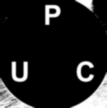

In [4]:
a.digestImage()

In [5]:
a.layers

{'image': <Libs.Beholder.Beholder_Layer at 0x7f22543b1810>,
 'gray': <Libs.Beholder.Beholder_Layer at 0x7f22543521a0>,
 'gray_letters': <Libs.Beholder.Beholder_Layer at 0x7f225022ec20>,
 'letters': 'VS\n\x0c'}

In [6]:
a.layers["letters"].splitlines()

['VS', '']

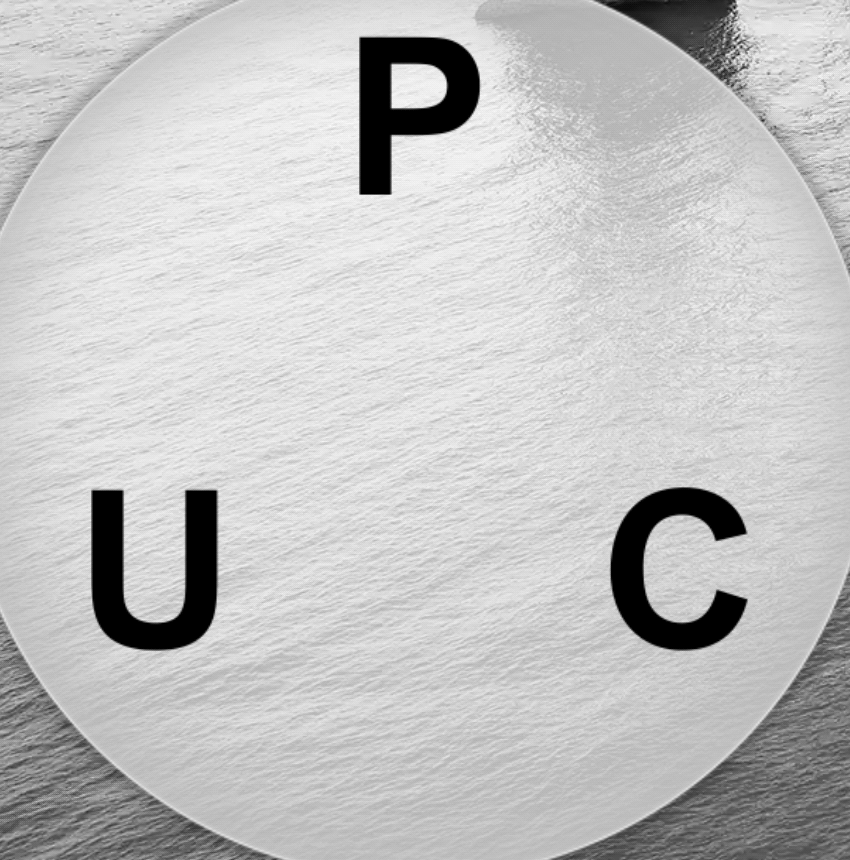

In [7]:
a.layers["gray_letters"].show()

In [8]:
from pathlib import Path

import requests

w = Path("words.lst")
if not w.exists():
    w.write_bytes(
        requests.get(
            "https://raw.githubusercontent.com/MariaLuo826/english_words/master/words_alpha.txt"
        ).content
    )